# Определение и прогнозирование успешности игры, для составления рекламной компании для следующего года

Нам предоставлены данные о продажах и оценке пользователей и экспертов, жанры и платформы игр. Необходимо изучить на основе данных особенности продаж игр в зависимости от их характеристик, сделать вывод о том, какие факторы определяют успешность игры.

Данные представляют собой информацию о выходе каждой игры с 1985 года и до 2016 года. В нашем распоряжении есть данные о названии игры, платформе для которой она вышла, год выхода, жанр, объемы продаж в млн. шт. в четырех различных регионах, таких как Америка, Европа, Япония и в целом по другим регионам. Также представлена для каждой игры оценка ее критиками, пользователями и возрастной рейтинг от ассоциации ESRB.

Задача исследования заключается в определении следующих параметров:

 - Определение топ-5 жанров игр для каждого из представленных регионов.
 - Определение топ-5 платформ
 - Определение степени занятости нишь относительно возрастного рейтинга esrb 

Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

## Изучение и обработка данных

### Импортирование необходимых библиотек, чтение файла с данными

In [180]:
# для того, что импортировать библиотеку missingno ее необходимо сначала установить, сделаем это с помощью следующей команды
!pip install -U missingno

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: missingno in /home/jovyan/.local/lib/python3.7/site-packages (0.5.0)


In [181]:
import pandas as pd
import missingno as msg
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st

In [182]:
data = pd.read_csv('/datasets/games.csv')
data.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [183]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Таким образом, получаем набор данных с различными типами столбцов, как числовые так и строкового типа. Также видим, что в данных есть большое количество пропусков в оценках игр и возрастного рейтинга. Перед непосредственно самим исследованием для начала проведем предобработку данных.

### Обработка данных

После ознакомления с данными проведем их подготовку и обработку, а именно, приведем названия столбцов к нижнему регистру, преобразуем некоторые столбцы к определенному типу данных в зависимости от особенностей их содержания, изучим и по возможности обработаем пропуски, проверим данные на наличие выбросов, а также на наличие дубликатов.

Начнем с приведения названия столбцов к нижнему регистру, для этого переименуем столбцы с помощью метода *rename*

In [184]:
data = data.rename(columns={'Name': 'name', 'Platform': 'platform', 'Year_of_Release': 'year_of_release', 
                    'Genre': 'genre', 'NA_sales': 'na_sales', 'EU_sales': 'eu_sales', 
                    'JP_sales': 'jp_sales', 'Other_sales': 'other_sales', 'Critic_Score': 'critic_score', 
                    'User_Score': 'user_score', 'Rating': 'rating'})

Теперь изучим пропуски в данных и удалим строки с пропусками (при их небольшом количестве). Для наглядного представления используем ранее импортированную библиотеку missingno для построения диаграммы пропусков.

''

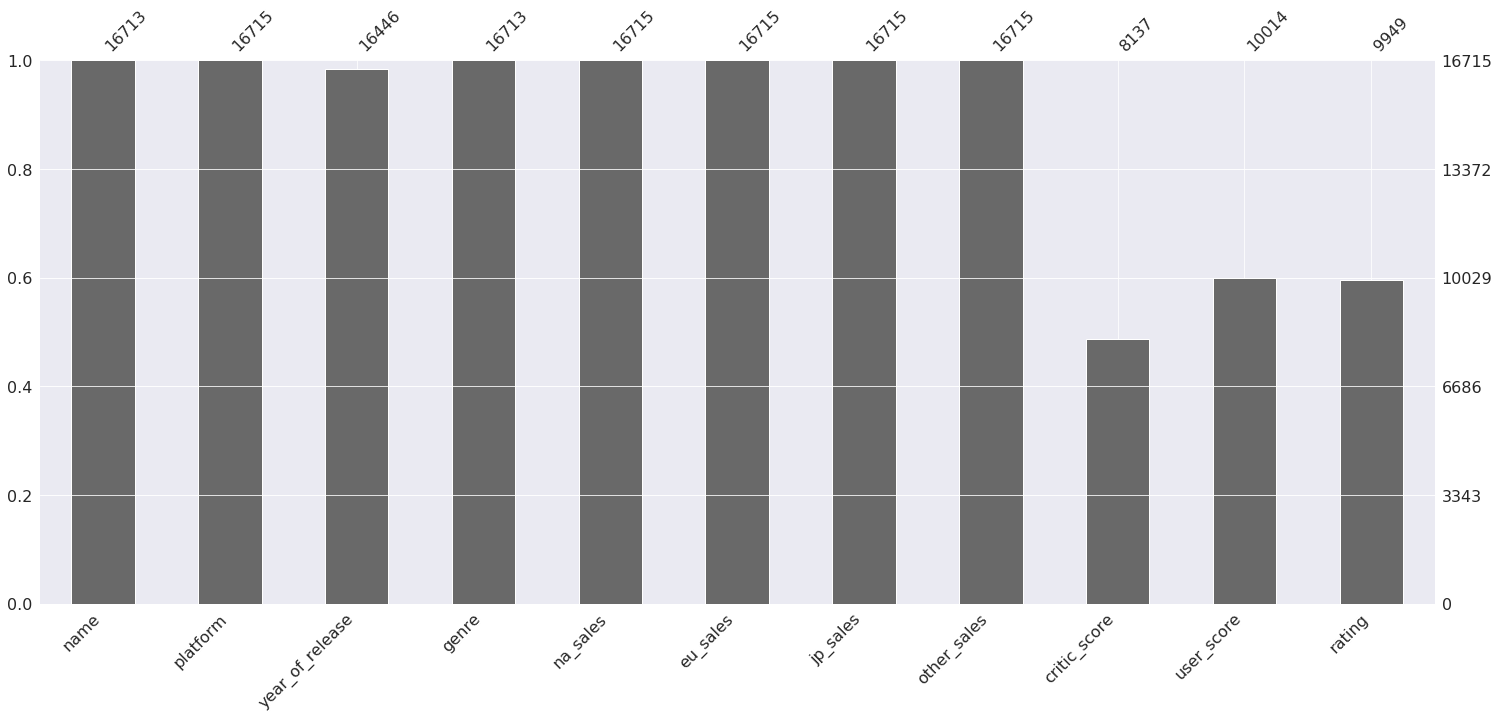

In [185]:
msg.bar(data)
;

Видим, что около половины пропусков находится в столбцах, содержащих информацию и рейтинге игры и оценке критиков и пользователей. Более детальный вывод по пропускам сделаем немного позже.

Для начала удалим строки с пропусками в столбце с годом выхода игры, таких строк совсем немного, всего 269, поэтому на дальнейшие исследование это не повлияет. Также удалим строки, где отсутствует информация о жанре и названии игры, таких всего 2.

In [186]:
data = data.drop(data.loc[data['year_of_release'].isna()].index)
data = data.drop(data.loc[data['name'].isna()].index)
data = data.drop(data.loc[data['genre'].isna()].index)

Приведем столбец с годом выхода игры к целочисленному типу с помощью метода *astype* для более понятного и удобного представления. Также столбец оценки пользователей содержит строковое значение "tbd", что означает еще неизвестное значение оценки. Эта аббривиатура часто применяется и при информации о дате выхода игр или обновления, когда разработчик к примеру сообщил, что игра или обновление выйдет, но не уточняет дату выхода продукта.

В данном случае это строковое значение необходимо заменить на значение пропуска nan, в противном случае при дальнейшем исследовании невозможно будет применить к этому столбцу статистические методы.

Пропуски в столбце **rating** заполним специальным маркером *"absent"*, что будет означать отсутствие возрастного рейтинга. 

In [187]:
data['year_of_release'] = data['year_of_release'].astype('int')
data.loc[data['user_score'] == 'tbd', 'user_score'] = np.nan
data['user_score'] = data['user_score'].astype('float')
data.loc[data['rating'].isna(), 'rating'] = 'absent'

Далее приведем все строковые значения столбцов к нижнему регистру, чтобы исключить наличие неявных дубликатов, после этого соответственно проверим данные на наличие дубликатов и при положительном результате удалим дубликаты.

In [188]:
data['name'] = data['name'].str.lower()
data['platform'] = data['platform'].str.lower()
data['genre'] = data['genre'].str.lower()
data['rating'] = data['rating'].str.lower()

In [189]:
data.duplicated().sum()

0

Получаем, что дубликатов в данных не обнаружено. Теперь проверим на выбросы данные в столбцах с годом выхода игры (на всякий случай), также в столбцах с оценкой пользователей и критиков. В столбцах количества продаж игр по регионам границы значений определить трудно, и нельзя будет точно сказать выброс ли то или иное значение, так как продажи могут быть как очень высокими, так и крайне низкими. В данном случае эти столбцы не рассматриваем.

''

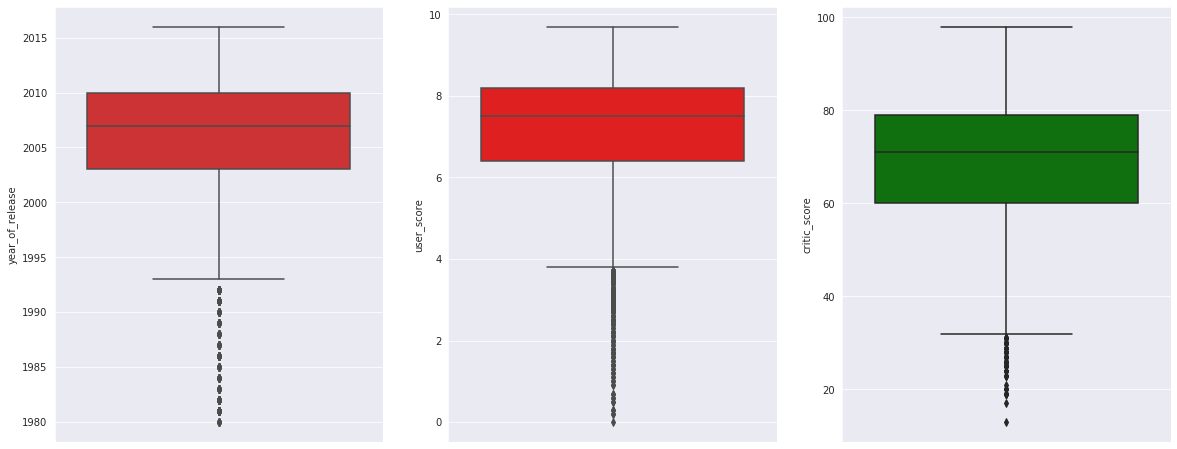

In [190]:
fig, ax = plt.subplots(1, 3, figsize=(20, 8))
sns.boxplot(x='year_of_release', data=data, orient='v', ax=ax[0])
sns.boxplot(x='user_score', data=data, orient='v', ax=ax[1], color='red')
sns.boxplot(x='critic_score', data=data, orient='v', ax=ax[2], color='green')
;

Из боксплотов видим, что выбросов в данных нет, все значения в пределах соответствующих границ.

Теперь посмотрим, есть ли зависимость между датой выхода игры и фактом наличия пропуска информации о оценках.

Для наглядности построим гистаграммы распределения значений столбцов **critic_score**, **user_score**, **rating** в зависимости от года выхода игры. Воспользуемся для этого методами библиотеки *matplotlib*.

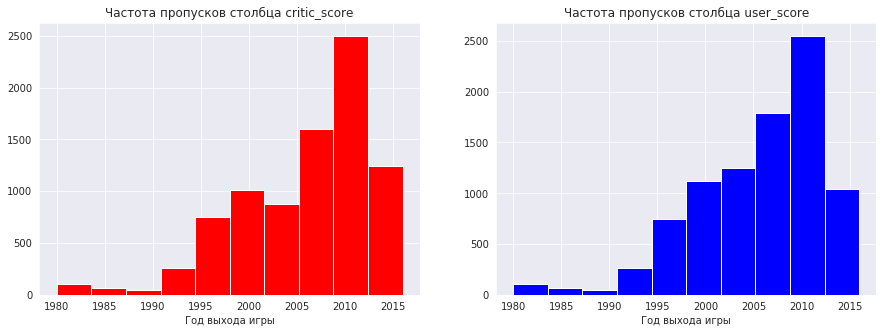

In [191]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Частота пропусков столбца critic_score')
plt.xlabel('Год выхода игры')
plt.hist(data.loc[data['critic_score'].isna(), 'year_of_release'], color='red')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Частота пропусков столбца user_score')
plt.xlabel('Год выхода игры')
plt.hist(data.loc[data['user_score'].isna(), 'year_of_release'], color='blue')
plt.grid(True)

plt.show()

Видим, что нет сильной зависимости от года выхода игры, в целом такие распределения получаюстя скорее в результате того, что количество выходящий игр с каждым годом очень сильно растет, а значит и растет доля не оцененных и не подвергнувшихся критике игр, хотя в 2010 году доля таковых наибольшая. 

Также важно заметить, что распределения практически одинаковые, что может означать тот факт, что все три столбца связаны между собой. То есть если у игры нет оценки от пользователей, значит чаще всего нет и оценки от критиков и присвоенного рейтинга возрастного ограничения, либо наоборот. В любом случае это вполне может означать, что все такие игры крайне непопулярные, чтобы их брались оценивать.

В данном случае заполнить пропуски не получится в столбцах оценок пользователей и критиков, по причине того, что это может сильно исказить данные и статистические тесты покажут не точные результаты, поэтом придется далее использовать только имеющиеся данные.

Посчитаем теперь суммарные продажи по регионам и сохраним в исходный датафрейм в столбец **sum_sales**.

In [192]:
data['sum_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
0,wii sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,e,82.54
1,super mario bros.,nes,1985,platform,29.08,3.58,6.81,0.77,NaN,NaN,absent,40.24
2,mario kart wii,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,e,35.52
3,wii sports resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8.0,e,32.77
4,pokemon red/pokemon blue,gb,1996,role-playing,11.27,8.89,10.22,1.00,NaN,NaN,absent,31.38


### Вывод

Таким образом мы обработали данные, привели к соответствующему типу нужные столбцы, проверили данные на наличие дубликатов и выбросов, которых не обнаружилось. Теперь можно переходить к исследовательскому анализу данных.

## Исследовательский анализ данных

### Количество игр в год

Исследовательский анализ начнем с ответа на вопрос, сколько игр выпускалось за каждый год, и важны ли данные за все периоды.
Для оценки и ответа на такой вопрос построим линейный график, для чего создадим сводную таблицу, сгруппированную по годам выпуска игр и содержащую данные о количестве таковых.

In [193]:
group_by_year = data.pivot_table(index='year_of_release', values='name', aggfunc='count')

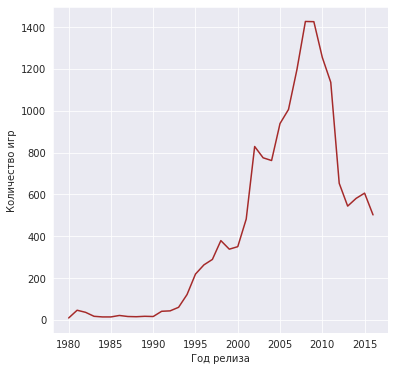

In [194]:
plt.figure(figsize=(6, 6))

plt.xlabel('Год релиза')
plt.ylabel('Количество игр')
plt.plot(group_by_year, color='brown')
plt.grid(True)
plt.show()

Получаем, что активный рост выпуска игр начался приблизительно с 1994 года, в более ранний период количество было очень малым и практически не менялось. Значит можно сделать вывод о том, что для дальнейшего исследования данные за такой большой период времени не нужны.

### Динамика продаж по платформам

Теперь посмотрим как менялись продажи по платформам. Выберем топ платформ по суммарным продажам и также построим график распределения по годам выхода игр. Далее необходимо определить, за какой срок в среднем появляются и исчезают новые платформы.

Выберем 4 платформы-лидеры по продажам игр. Для этого создадим сводную таблицу, где сгруппируем данные по платформам, а значения используем из столбца суммы продаж по всем регионам, для которых посчитаем максимальное значение и общую сумму для каждой платформы.

In [195]:
group_by_platform = data.pivot_table(index='platform', values='sum_sales', aggfunc=['max', 
                                                                                    'sum'])
group_by_platform.set_axis(['max', 'sum'], axis='columns', inplace=True)
print(group_by_platform.sort_values(by='sum', ascending=False).head(10))
print(group_by_platform.sort_values(by='max', ascending=False).head(10))

            max      sum
platform                
ps2       20.81  1233.56
x360      21.82   961.24
ps3       21.05   931.34
wii       82.54   891.18
ds        29.80   802.78
ps        10.95   727.58
ps4       14.63   314.14
gba       15.84   312.88
psp        7.68   289.53
3ds       14.60   257.81
            max      sum
platform                
wii       82.54   891.18
nes       40.24   251.05
gb        31.38   254.43
ds        29.80   802.78
x360      21.82   961.24
ps3       21.05   931.34
ps2       20.81  1233.56
snes      20.62   200.04
gba       15.84   312.88
ps4       14.63   314.14


Получаем, что платформы ps2, x360, ps3, wii - лидеры по объемам выпуска игр, wii, nes, gb, ds - лидеры по максимальному объему выпкска какой-то отдельно взятой игры. Рассмотрим в таком случае ps2, x360, wii и ds.

Построим соответственно 4 графика, показывающие, сколько игр выпускались на данных платформах по годам. Создадим сводные таблицы аналогичные таблице предыдущего пункта, только с данными для каждой из платформ.

In [196]:
group_for_ps2 = data[data['platform'] == 'ps2'].pivot_table(index='year_of_release', values='name', aggfunc='count')
group_for_x360 = data[data['platform'] == 'x360'].pivot_table(index='year_of_release', values='name', aggfunc='count')
group_for_wii = data[data['platform'] == 'wii'].pivot_table(index='year_of_release', values='name', aggfunc='count')
group_for_ds = data[data['platform'] == 'ds'].pivot_table(index='year_of_release', values='name', aggfunc='count')

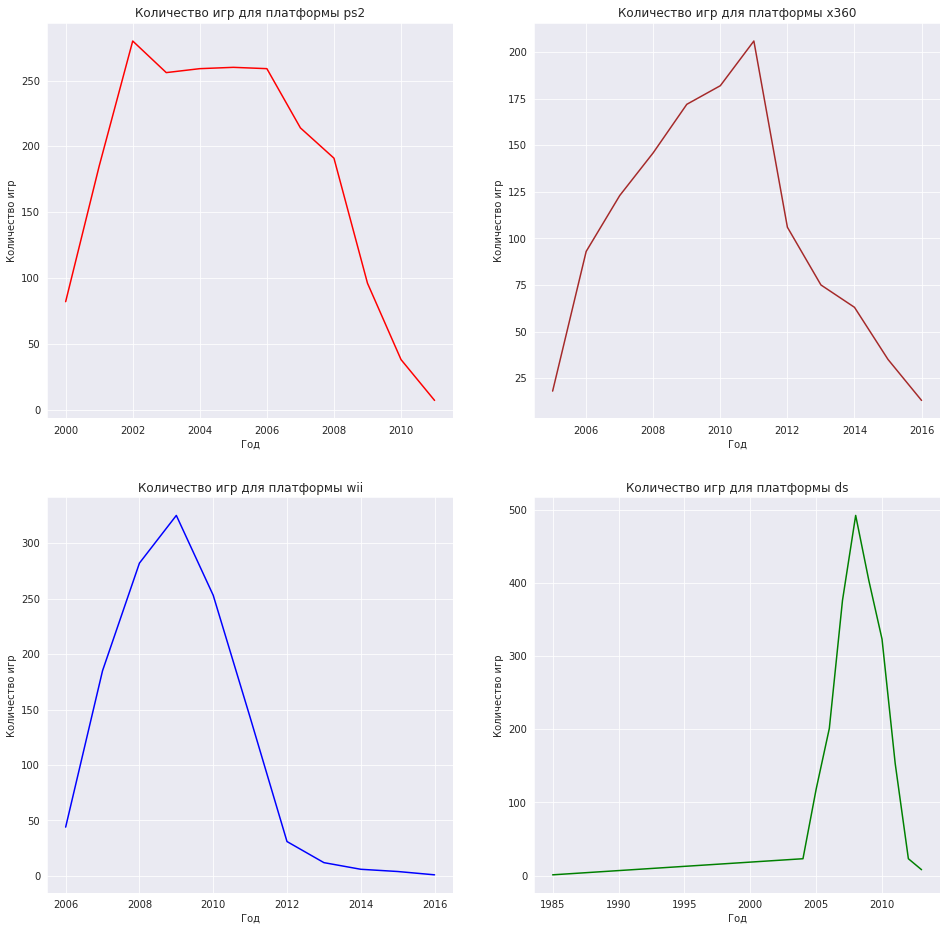

In [197]:
plt.figure(figsize=(16, 16))

plt.subplot(2, 2, 1)
plt.title('Количество игр для платформы ps2')
plt.xlabel('Год')
plt.ylabel('Количество игр')
plt.plot(group_for_ps2, color='red')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.title('Количество игр для платформы x360')
plt.xlabel('Год')
plt.ylabel('Количество игр')
plt.plot(group_for_x360, color='brown')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.title('Количество игр для платформы wii')
plt.xlabel('Год')
plt.ylabel('Количество игр')
plt.plot(group_for_wii, color='blue')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.title('Количество игр для платформы ds')
plt.xlabel('Год')
plt.ylabel('Количество игр')
plt.plot(group_for_ds, color='green')
plt.grid(True)
plt.show()

Как видно из графиков, самой долго живущей оказалась платформа ps2, что не удивительно, игры для нее выпускались на протяжении 10 лет, похожая ситуация с x360, для нее игры выпускались также около 10 лет, в случае с wii видно, что для нее активно выпускались игры только на протяжении 5-6 лет, далее начался спад и в 2016 году уже почти ничего не выпускалось. Платформа ds в противовес трем предыдущим видимо появилась намного раньше, завершила свою существование в 2011-2012 годах.

Рассмотрим еще 4 платформы, чтобы сделать более точный вывод о том, сколько приблизительно лет живут платформы без обновлений.

In [198]:
group_for_ps3 = data[data['platform'] == 'ps3'].pivot_table(index='year_of_release', values='name', aggfunc='count')
group_for_gb = data[data['platform'] == 'gb'].pivot_table(index='year_of_release', values='name', aggfunc='count')
group_for_nes = data[data['platform'] == 'nes'].pivot_table(index='year_of_release', values='name', aggfunc='count')
group_for_psp = data[data['platform'] == 'psp'].pivot_table(index='year_of_release', values='name', aggfunc='count')

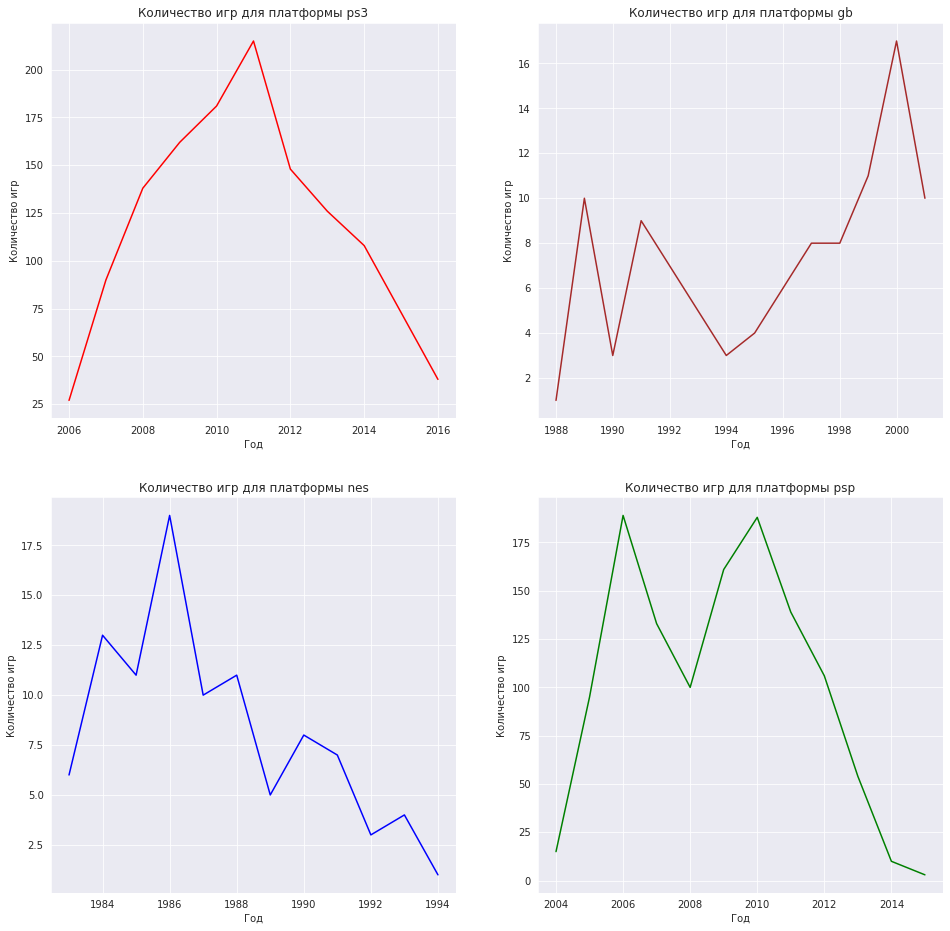

In [199]:
plt.figure(figsize=(16, 16))

plt.subplot(2, 2, 1)
plt.title('Количество игр для платформы ps3')
plt.xlabel('Год')
plt.ylabel('Количество игр')
plt.plot(group_for_ps3, color='red')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.title('Количество игр для платформы gb')
plt.xlabel('Год')
plt.ylabel('Количество игр')
plt.plot(group_for_gb, color='brown')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.title('Количество игр для платформы nes')
plt.xlabel('Год')
plt.ylabel('Количество игр')
plt.plot(group_for_nes, color='blue')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.title('Количество игр для платформы psp')
plt.xlabel('Год')
plt.ylabel('Количество игр')
plt.plot(group_for_psp, color='green')
plt.grid(True)
plt.show()

В данном случае также видим, что каждая из представленных платформ просуществовала около 10 лет, поэтому даже на данный момент можно сделать вывод о том, что даже крупные и популярные платформы не живут без обновления более 10 лет и при выборе платформы для новых игровых продуктов стоит рассматривать только новые и актуальные платформы, то есть обновленные версии популярных платформ и возможно совершенно новые, только вышедшие на рынок.

### Актуальные данные

Создадим срез актуальных данных, то есть данные по тем играм, которые выходили начиная с 2013 года и позже.

In [200]:
data = data[data['year_of_release'] >= 2013]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2233 entries, 16 to 16714
Data columns (total 12 columns):
name               2233 non-null object
platform           2233 non-null object
year_of_release    2233 non-null int64
genre              2233 non-null object
na_sales           2233 non-null float64
eu_sales           2233 non-null float64
jp_sales           2233 non-null float64
other_sales        2233 non-null float64
critic_score       991 non-null float64
user_score         1192 non-null float64
rating             2233 non-null object
sum_sales          2233 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 226.8+ KB


Выборка получилась вполне репрезентативной, что позволит получить корректные результаты при исследовании различных показателей.

### Лидирующие платформы

Далее ответим на следующий вопрос. Какие платформы лидируют по продажам, растут или падают? Необходимо выбрать несколько потенциально самых прибыльных платформ.

Для этого создадим сводную таблицу аналогичную предыдущей в пункте 2.2, где мы выбирали самые крупные по продажам для них игр платформы. В данном случае поступим аналогично, для новых актуальных данных создадим сводную таблицу, сгруппировав данные по платформам и вычислим для них сумму продаж по всем регионам, то есть используя столбец **sum_sales**.

In [201]:
group_by_platform_new = data.pivot_table(index='platform', values='sum_sales', aggfunc=['sum', 'mean'])
group_by_platform_new.set_axis(['sum', 'mean'], axis='columns', inplace=True)
group_by_platform_new.sort_values(by='sum', ascending=False).head(10)

,sum,mean
platform,,
ps4,314.14,0.801378
ps3,181.43,0.525884
xone,159.32,0.645020
3ds,143.25,0.472772
x360,136.80,0.735484
wiiu,64.63,0.562000
pc,39.43,0.208624
psv,32.99,0.092151
wii,13.66,0.593913


Получаем, что самые прибыльные платформы это ps3, ps4, xone, 3ds (выберем первые 4, по объему проданных копий). Теперь посмотрим на динамику количества продаж игр для них с течением времени, в данном случае с 2010 года до момента данного исследования. Создадим сводные таблицы аналогично пункту 2.2 и построим графики.  

In [202]:
grouped_for_ps3 = data[data['platform'] == 'ps3'].pivot_table(index='year_of_release', values='sum_sales', aggfunc='mean')
grouped_for_xone = data[data['platform'] == 'xone'].pivot_table(index='year_of_release', values='sum_sales', aggfunc='mean')
grouped_for_ps4 = data[data['platform'] == 'ps4'].pivot_table(index='year_of_release', values='sum_sales', aggfunc='mean')
grouped_for_3ds = data[data['platform'] == '3ds'].pivot_table(index='year_of_release', values='sum_sales', aggfunc='mean')

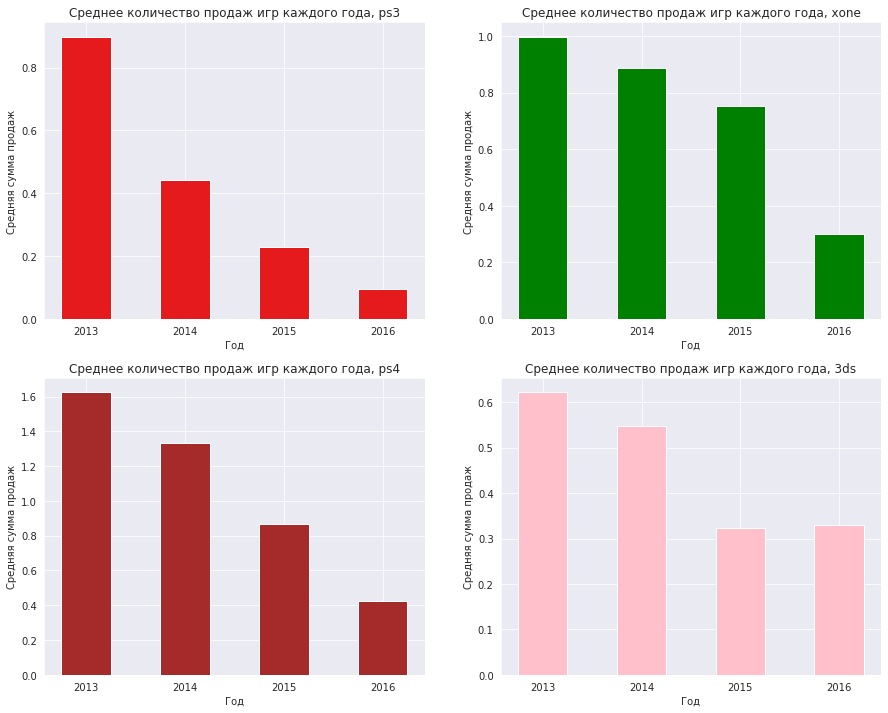

In [203]:
plt.figure(figsize=(15, 12))

plt.subplot(2, 2, 1)
plt.title('Среднее количество продаж игр каждого года, ps3')
plt.xlabel('Год')
plt.ylabel('Средняя сумма продаж')
plt.bar(['2013', '2014', '2015', '2016'], grouped_for_ps3['sum_sales'], width=0.5)
plt.grid(True)

plt.subplot(2, 2, 2)
plt.title('Среднее количество продаж игр каждого года, xone')
plt.xlabel('Год')
plt.ylabel('Средняя сумма продаж')
plt.bar(['2013', '2014', '2015', '2016'], grouped_for_xone['sum_sales'], width=0.5, color='green')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.title('Среднее количество продаж игр каждого года, ps4')
plt.xlabel('Год')
plt.ylabel('Средняя сумма продаж')
plt.bar(['2013', '2014', '2015', '2016'], grouped_for_ps4['sum_sales'], width=0.5, color='brown')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.title('Среднее количество продаж игр каждого года, 3ds')
plt.xlabel('Год')
plt.ylabel('Средняя сумма продаж')
plt.bar(['2013', '2014', '2015', '2016'], grouped_for_3ds['sum_sales'], width=0.5, color='pink')
plt.grid(True)
plt.show()

Из диаграмм видно, что с начала периода 2013-2016 годов лидером была платформа ps4, после чего с весомым преимуществом лидирует по продажам платформа one, также не смотря на общую тенденцию к снижению количества продаж платформа 3ds в 2016 году немного выросла относительно прошлого года, в то время как остальные упали. Можно сделать вывод о том, что наиболее привлекательны для продвижения игр будут платформы ps4 и 3ds.

### Распределение суммы продаж

Построим теперь боксплоты для этих платформ по значениям суммы продаж. На первом графике отобразим данные без ограничений по оси y для оценки выбросов, на втором же масшабируем график для более точного представления.

In [205]:
boxplots = data.loc[data['platform'].isin(['ps3', 'xone', 'ps4', '3ds'])]

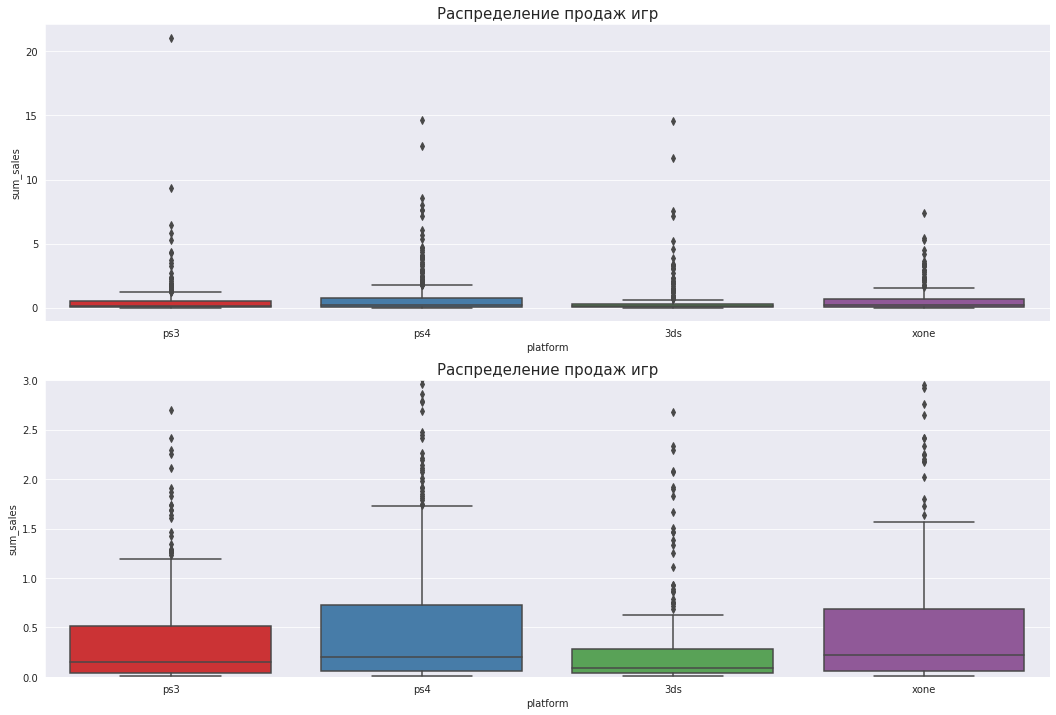

In [206]:
plt.figure(figsize=(18, 12))

plt.subplot(2, 1, 1)
plt.title('Распределение продаж игр', fontsize=15)
sns.boxplot(x='platform', y='sum_sales', data=boxplots)
sns.set_style('darkgrid')
sns.set_palette('Set1')

plt.subplot(2, 1, 2)
plt.title('Распределение продаж игр', fontsize=15)
sns.boxplot(x='platform', y='sum_sales', data=boxplots)
sns.set_style('darkgrid')
plt.ylim(0, 3)
sns.set_palette('Set1')

plt.show()

Видим, что в основном сумма продаж сосредоточена в пределах 0.1-1.5 млн штук, но встречаются и игры, которые продавались и значительно большими тиражами, это характерно для всех рассматриваемых платформ. 

Отдельные точечные значения на графиках со статистической точки зреня считаются выбросами, но в нашем случае этими данными являются отдельные очень хорошо продаваемые игры, которые очень сильно опережают по продажам основное большинство других конкурирующих игр.

### Корреляция параметров

Теперь необходимо узнать, как влияют на продажи внутри одной платформы отзывы покупателей и критиков. Рассмотрим такое влияние (если оно существует) на примере выбранных 2 платформ, xone и ps4.

Для этого используем срезы для каждой платформы, затем построим диаграмму рассеяния и вычислим коэффициенты корреляции между числом продаж и оценкой пользователей и критиков. Начем с диаграммы рассеяния. Построим ее в виде матрицы сразу же для всех параметров с помощью метода *pd.plotting.scatter_matrix*.

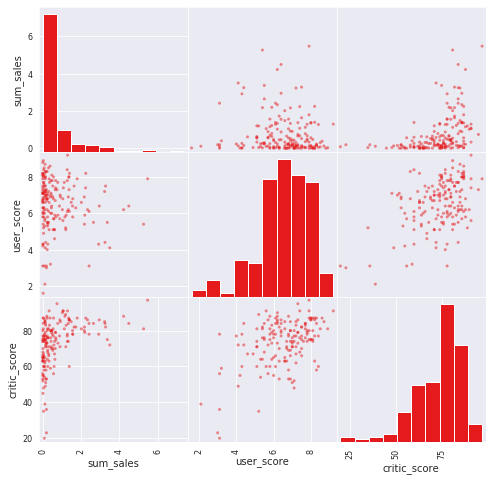

In [207]:
xone = data.loc[data['platform'] == 'xone']
pd.plotting.scatter_matrix(xone.loc[:, ['sum_sales', 'user_score', 'critic_score']], figsize=(8,8))
plt.show()

Видим, что интересующие нас зависимости между суммой продаж и оценкой критиков и пользователей все же есть, причем зависимость от оценке критиков кажется более сильной, впрочем этот факт подтвердят или опровергнут коэффициенты корреляции, которым вычслим ниже. Также для удобства и наглядности предствим их в виде графика heatmap. Сами коэффициенты вычислим c помощью метода *corr()*

In [208]:
corr_xone = xone.loc[:, ['sum_sales', 'user_score', 'critic_score']].corr()

Проделаем теперь тоже самое для платформы ps4.

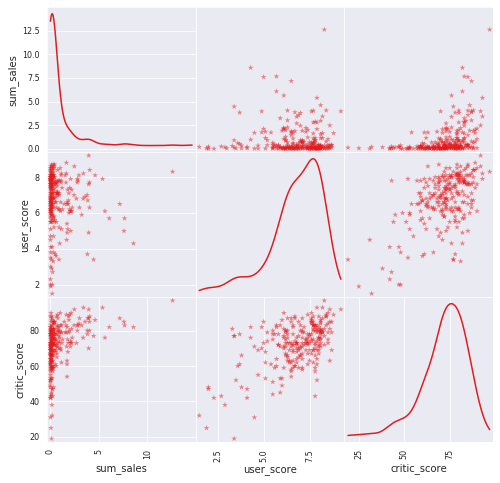

In [209]:
ps4 = data.loc[data['platform'] == 'ps4']
pd.plotting.scatter_matrix(ps4.loc[:, ['sum_sales', 'user_score', 'critic_score']], marker='*', diagonal='kde', figsize=(8,8))
plt.show() 

Для платформы ps4 видим практически такую же картину зависимостей, хотя кажется что в данном случае сумма продаж чуть менее чувствительна к оценкам пользователей и критиков. Далее аналогично вычислим коэффициенты корреляции и построим два графика heatmap для сравнения.

In [210]:
corr_ps4 = ps4.loc[:, ['sum_sales', 'user_score', 'critic_score']].corr()

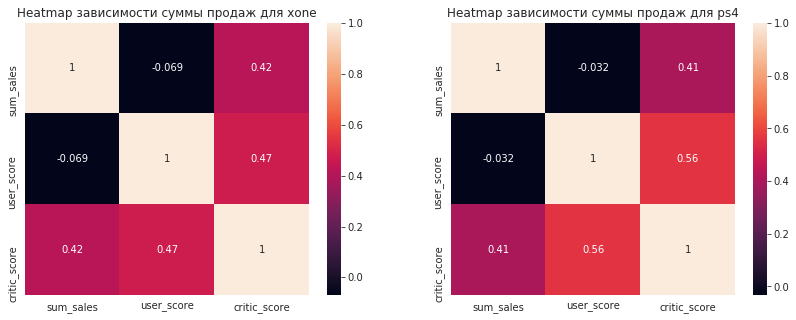

In [211]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.title('Heatmap зависимости суммы продаж для xone')
sns.heatmap(corr_xone, annot=True)
plt.subplot(1, 2, 2)
plt.title('Heatmap зависимости суммы продаж для ps4')
sns.heatmap(corr_ps4, annot=True)
plt.show()

Таким образом, получаем, что зависимость суммы продаж от оценки пользователей практически отсутствует, но относительно оценки критиков зависимость все же есть, и в случае платформы xone она чуть более сильная. Это может быть вызвано тем фактом, что сама платформа и игры к ней вышли на рынок сравнительно недавно и многие относятся скептически к покупки нового продукта, поэтому более тщательно изучают мнения различных экспертов. 

Также вероятно можно сделать вывод и том, что сумма продаж, которая имеет зависимость от оценки критиков на самом деле от существует как-бы сама по себе. То есть сами пользователи определяют качество игр, что и создает повышенный спрос на определенный контент, в то время как оценки критиков просто подтверждают данный факт. Возможно также и влияние суммы продаж на оценку критиков, но нам неизвестно в какой момент времени проводилась экспертная оценка каждой игры, поэтому уверенности в корректности данного обзаца не так много =). Главное, что зависимость существует и ее нельзя игнорировать при дальнейших исследованиях.

Для большей точности выводов построим еще два хитмепа для ранее рассматриваемых платформ, а именно для ps3 и 3ds.

In [212]:
ps3 = data.loc[data['platform'] == 'ps3']
ds_3 = data.loc[data['platform'] == '3ds']

corr_ps3 = ps3.loc[:, ['sum_sales', 'user_score', 'critic_score']].corr()
corr_ds_3 = ds_3.loc[:, ['sum_sales', 'user_score', 'critic_score']].corr()

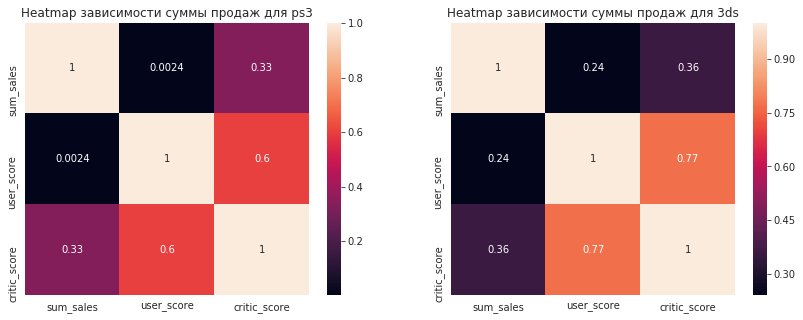

In [213]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.title('Heatmap зависимости суммы продаж для ps3')
sns.heatmap(corr_ps3, annot=True)
plt.subplot(1, 2, 2)
plt.title('Heatmap зависимости суммы продаж для 3ds')
sns.heatmap(corr_ds_3, annot=True)
plt.show()

В данном случае ситуация с зависимостью от оценки критиков аналогичная, что отчасти подтверждает сделанные выше выводы. Также стоит принять во внимания тот факт, что существует и небольшая зависимость для платформы 3ds от ценки пользователей, по крайней мере она намного больше, чем для трех других платформ. Возможно это связано с обобенностями самих игр их жанров и возрастных ограничений.

### Объемы продаж для каждого жанра

Завершая данный раздел, посмотрим на распределение игр по жанрам, а именно какие составляют объемы продаж для каждого жанра, какие присуствуют особенности для таких показателей относительно жанров игр. Построим две диаграммы, на одной отобразим суммарное количество продаж, а на второй продаваемость игр определенного жанра, иными словами общую сумму продаж для каждого жанра деленную на количество продаж. Таким образом мы получим такой показатель, который можно сравнивать между жанрами не взирая объемы продаж. То есть он будет показывать как много различных игр в конкретном жанре, можно даже сказать, насколько конкурентная среда именно в отдельном жанре. Также этот способ сравнения применим и далее, в другом пункте исследования.

Для этого создадим сводную таблицу, где сгруппируем данные по жанрам и создадим два столбца с количеством и суммой продаж. Затем добавим новый столбец в получившуюся таблицу, который будет являться отношением столбца суммы к столбцу количества и построим два графика, как уже выше отмечали, по столбцу суммы и новому столбцу отношения.

In [215]:
group_by_genre_all = data.pivot_table(index='genre', values='sum_sales', aggfunc=['sum', 'count'])
group_by_genre_all.set_axis(['sum', 'count'], axis='columns', inplace=True)
group_by_genre_all['ration'] = group_by_genre_all['sum']/group_by_genre_all['count']

In [216]:
# Получим список жанров для дальнейшего использования при редактировании графиков
name_of_genres = group_by_genre_all.index

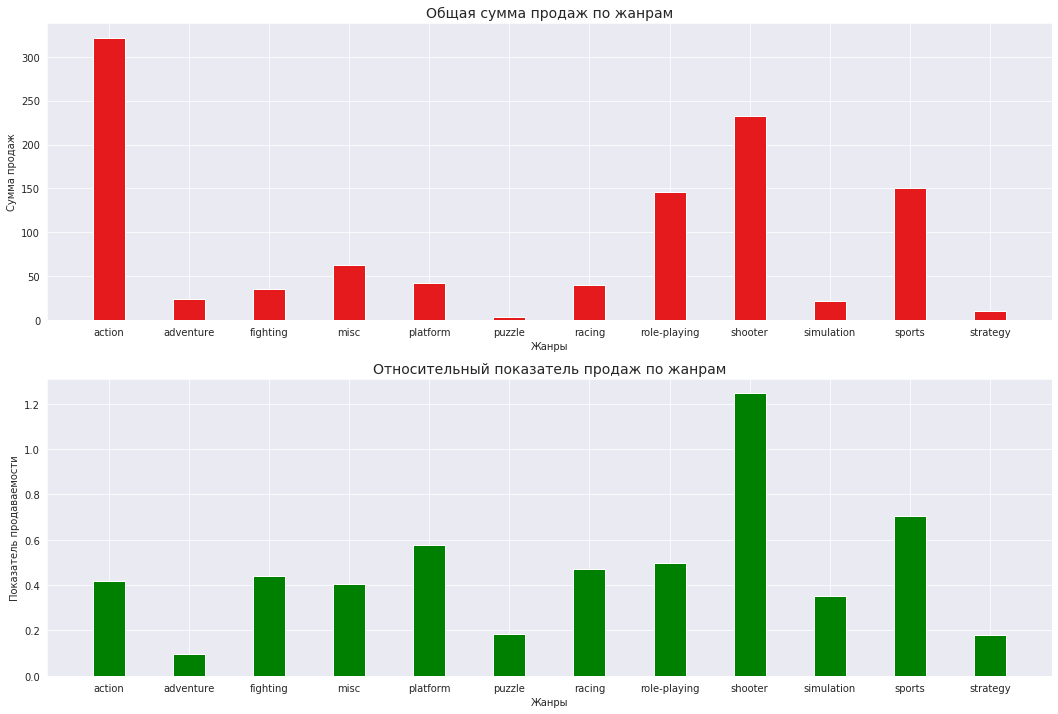

In [217]:
# Переменную со списком жанров мы уже создавали выше
plt.figure(figsize=(18, 12))

plt.subplot(2, 1, 1)
plt.title('Общая сумма продаж по жанрам', fontsize=14)
plt.xlabel('Жанры')
plt.ylabel('Сумма продаж')
plt.bar(name_of_genres, group_by_genre_all['sum'], width=0.4)

plt.subplot(2, 1, 2)
plt.title('Относительный показатель продаж по жанрам', fontsize=14)
plt.xlabel('Жанры')
plt.ylabel('Показатель продаваемости')
plt.bar(name_of_genres, group_by_genre_all['ration'], width=0.4, color='green')
plt.show()

Таким образом получаем, что по абсолютному показателю, то есть по общей сумме продаж лидирует такой жанр как *action*, затем идут *shooter*, *sports* и *role-playing*. Но ситуация с относительным показателем продаваемости, то есть отношением объема продаж к количеству проданных игр, совершенно другая. Здесь уже жанр *action* занимает средние позиции, а лидирует *shooter* и *sports*. Это означает, что эти жанры наименее насыщенны количеством различных игр, следовательны более привлекательны для внедрения нового контента. 

## Составление портрета пользователя каждого региона

### Топ-5 платформ

Теперь будем исследовать различные параметры в разбивке пользователей по регионам. Для этого создадим 4 среза данных, где будет информация о продажах игр в Америке, Европе, Японии и других регионах. Необходимо ответить на вопросы:
 - Топ 5 самых популярных платформ
 - Топ 5 самых популярных жанров
 - Влияет ли рейтинг ESRB на продажи в отдельном регионе?

В данном случае будем использовать только суммарное количество продаж как показатель популярности, по причине того, что необходимо учесть количество разнообразных игр выпускаемых для конкретной платформы. Если платформа популярна, то новые игры скорее всего появятся именно для нее, и, вероятно, только после того как наберут популярность, то их выпустят и для других платформ.

Начнем с определения 5 самых популярных платформ в зависимости от региона. Для создадим сводные таблицы для получения суммарного количества продаж для каждой из платформ для каждого региона, затем отсортируем в порядке убывания по сумме продаж. После чего построим 4 круговых диаграммы, показывающие соотношение объемов продаж в каждом из регионов.

In [218]:
data_at_na = data.pivot_table(index='platform', values='na_sales', aggfunc='sum')
data_at_na.set_axis(['sum_sales'], axis='columns', inplace=True)
data_at_na = data_at_na.sort_values(by='sum_sales', ascending=False)
data_at_na.head()

,sum_sales
platform,
ps4,108.74
xone,93.12
x360,81.66
ps3,63.50
3ds,38.20


In [219]:
data_at_eu = data.pivot_table(index='platform', values='eu_sales', aggfunc='sum')
data_at_eu.set_axis(['sum_sales'], axis='columns', inplace=True)
data_at_eu = data_at_eu.sort_values(by='sum_sales', ascending=False)
data_at_eu.head()

,sum_sales
platform,
ps4,141.09
ps3,67.81
xone,51.59
x360,42.52
3ds,30.96


In [220]:
data_at_jp = data.pivot_table(index='platform', values='jp_sales', aggfunc='sum')
data_at_jp.set_axis(['sum_sales'], axis='columns', inplace=True)
data_at_jp = data_at_jp.sort_values(by='sum_sales', ascending=False)
data_at_jp.head()

,sum_sales
platform,
3ds,67.81
ps3,23.35
psv,18.59
ps4,15.96
wiiu,10.88


In [221]:
data_at_other = data.pivot_table(index='platform', values='other_sales', aggfunc='sum')
data_at_other.set_axis(['sum_sales'], axis='columns', inplace=True)
data_at_other = data_at_other.sort_values(by='sum_sales', ascending=False)
data_at_other.head()

,sum_sales
platform,
ps4,48.35
ps3,26.77
xone,14.27
x360,12.11
3ds,6.28


Таким образом мы получили топ-5 платформ для каждого из регионов, теперь для наглядности отобразим эту информацию в виде круговых диаграмм.

In [222]:
labels_na = data_at_na.index[:5]
labels_eu = data_at_eu.index[:5]
labels_jp = data_at_jp.index[:5]
labels_other = data_at_other.index[:5]

data_for_na = data_at_na['sum_sales'][:5]
data_for_eu = data_at_eu['sum_sales'][:5]
data_for_jp = data_at_jp['sum_sales'][:5]
data_for_other = data_at_other['sum_sales'][:5]

In [223]:
explode = [0.02, 0.05, 0.08, 0.08, 0.05]

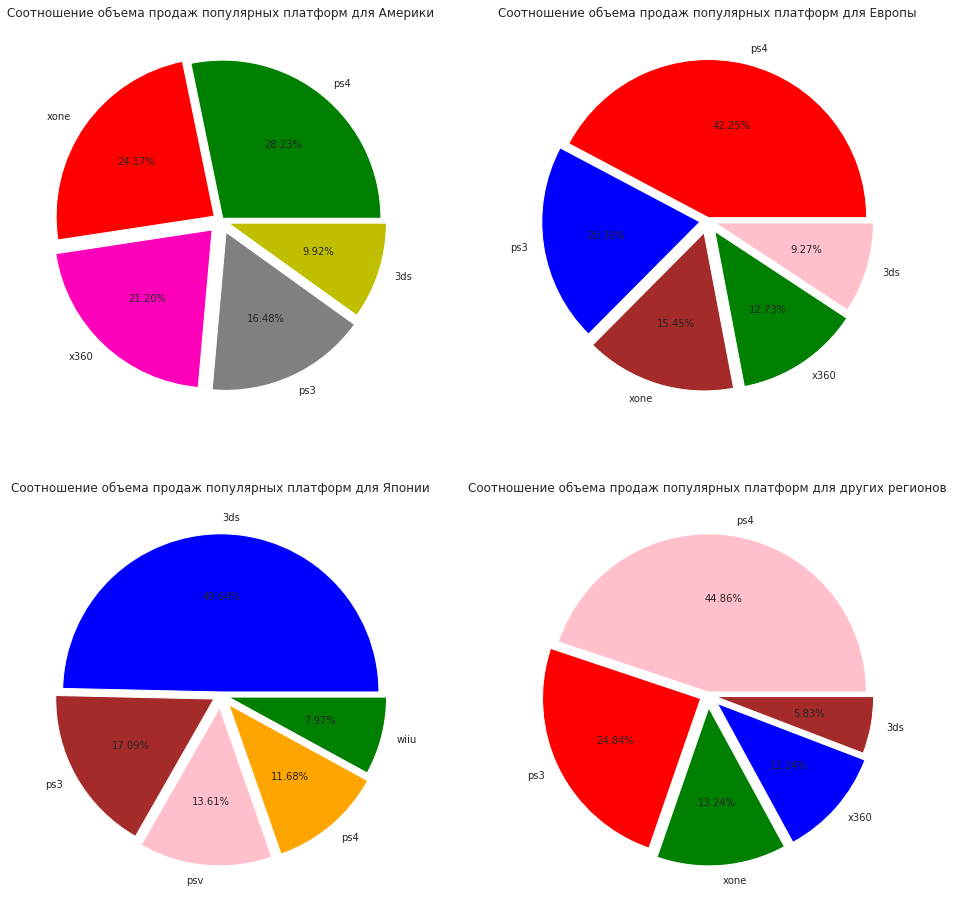

In [224]:
plt.figure(figsize=(16, 16))

plt.subplot(2, 2, 1)
plt.title('Соотношение объема продаж популярных платформ для Америки', fontsize=12)
plt.pie (data_for_na, explode=explode, 
         colors=["g", "r", "#FF00BB", "0.5", "y"], 
         labels=labels_na, autopct='%1.2f%%')
plt.subplot(2, 2, 2)
plt.title('Соотношение объема продаж популярных платформ для Европы', fontsize=12)
plt.pie (data_for_eu, explode=explode, 
         colors=["r", "b", "brown", "g", "pink"], 
         labels=labels_eu, autopct='%1.2f%%')
plt.subplot(2, 2, 3)
plt.title('Соотношение объема продаж популярных платформ для Японии', fontsize=12)
plt.pie (data_for_jp, explode=explode, 
         colors=["blue", "brown", "pink", "orange", "g"], 
         labels=labels_jp, autopct='%1.2f%%')
plt.subplot(2, 2, 4)
plt.title('Соотношение объема продаж популярных платформ для других регионов', fontsize=12)
plt.pie (data_for_other, explode=explode, 
         colors=["pink", "red", "green", "blue", "brown"], 
         labels=labels_other, autopct='%1.2f%%')
plt.show()

Таким образом, получаем, что в Америке преобладают платформы xone и ps4, в Европе ps3 и ps4, в Японии 3ds и ps3 (не удивительно), в других регионах предпочтения также как и в Европе отдают ps3 и ps4. В Японии по непонятным причинам ps4 еще не успела завоевать популярность.

### Топ-5 жанров 

In [225]:
# Создадим сводные таблицы сгруппируя данные по жанрам, таких таблиц получится 4, каждая для одного из регионов

group_by_genre_na = data.pivot_table(index='genre', values='na_sales', aggfunc=['sum', 'max', 'mean'])
group_by_genre_na.set_axis(['sum', 'max', 'mean'], axis='columns', inplace=True)
group_by_genre_eu = data.pivot_table(index='genre', values='eu_sales', aggfunc=['sum', 'max', 'mean'])
group_by_genre_eu.set_axis(['sum', 'max', 'mean'], axis='columns', inplace=True)
group_by_genre_jp = data.pivot_table(index='genre', values='jp_sales', aggfunc=['sum', 'max', 'mean'])
group_by_genre_jp.set_axis(['sum', 'max', 'mean'], axis='columns', inplace=True)
group_by_genre_other = data.pivot_table(index='genre', values='other_sales', aggfunc=['sum', 'max', 'mean'])
group_by_genre_other.set_axis(['sum', 'max', 'mean'], axis='columns', inplace=True)

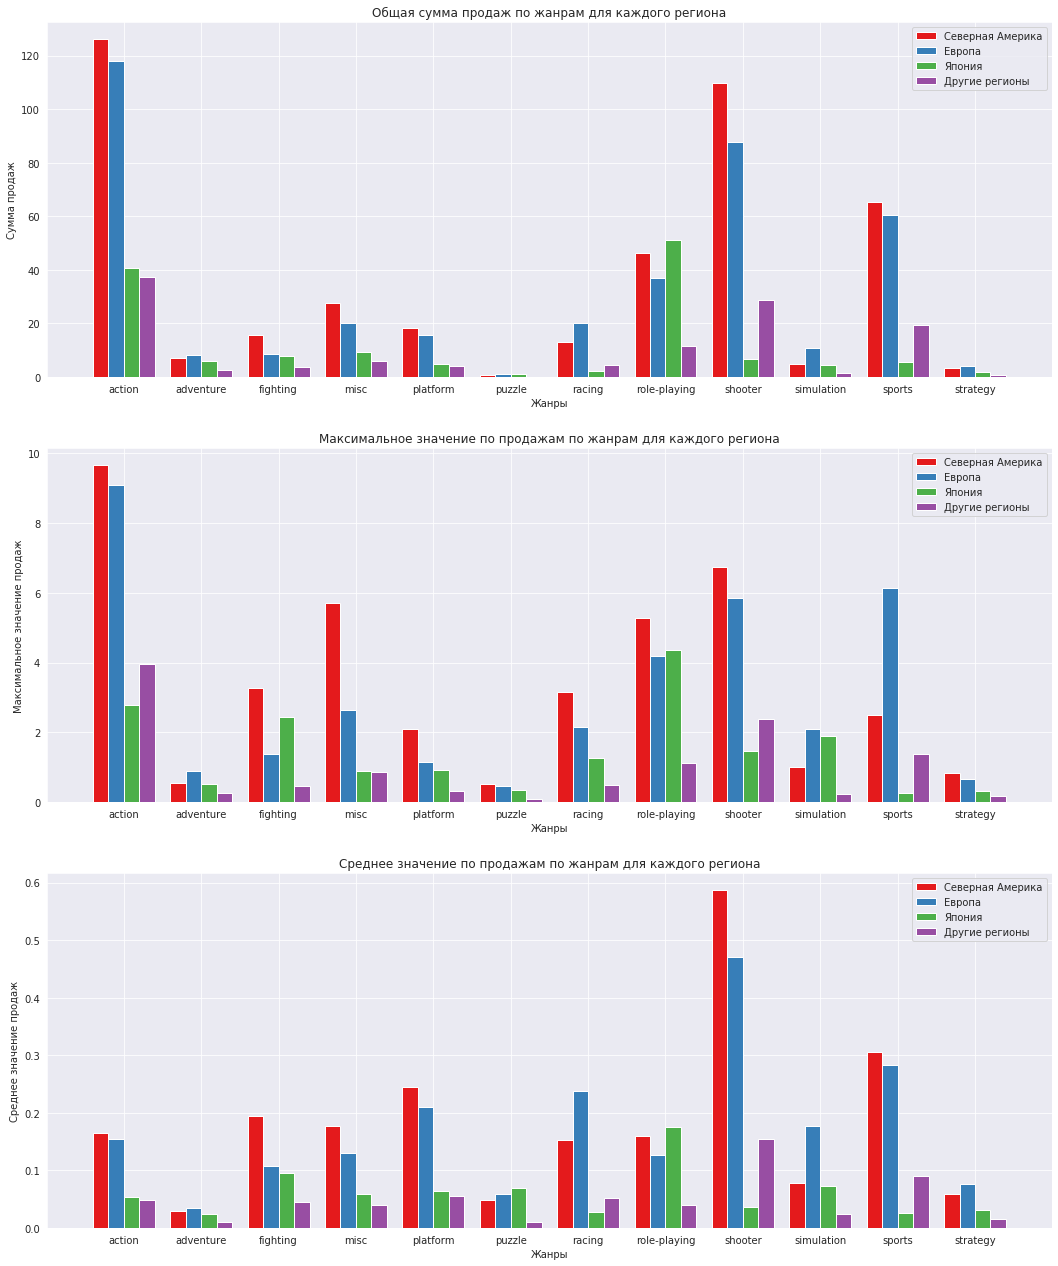

In [226]:
width = 0.2
y_na_sum = group_by_genre_na['sum']
y_eu_sum = group_by_genre_eu['sum']
y_jp_sum = group_by_genre_jp['sum']
y_other_sum = group_by_genre_other['sum']

x_indexes = np.arange(len(name_of_genres))

plt.figure(figsize=(18, 30))

plt.subplot(4, 1, 1)
plt.title('Общая сумма продаж по жанрам для каждого региона')
plt.xticks(x_indexes, name_of_genres)
plt.xlabel('Жанры')
plt.ylabel('Сумма продаж')
plt.bar(x_indexes-(0.3), y_na_sum, label='Северная Америка', width=width)
plt.bar(x_indexes-(0.1), y_eu_sum, label='Европа', width=width)
plt.bar(x_indexes+(0.1), y_jp_sum, label='Япония', width=width)
plt.bar(x_indexes+(0.3), y_other_sum, label='Другие регионы', width=width)
plt.legend()

plt.subplot(4, 1, 2)
plt.title('Максимальное значение по продажам по жанрам для каждого региона')
plt.xticks(x_indexes, name_of_genres)
plt.xlabel('Жанры')
plt.ylabel('Максимальное значение продаж')
plt.bar(x_indexes-(0.3), group_by_genre_na['max'], label='Северная Америка', width=width)
plt.bar(x_indexes-(0.1), group_by_genre_eu['max'], label='Европа', width=width)
plt.bar(x_indexes+(0.1), group_by_genre_jp['max'], label='Япония', width=width)
plt.bar(x_indexes+(0.3), group_by_genre_other['max'], label='Другие регионы', width=width)
plt.legend()

plt.subplot(4, 1, 3)
plt.title('Среднее значение по продажам по жанрам для каждого региона')
plt.xticks(x_indexes, name_of_genres)
plt.xlabel('Жанры')
plt.ylabel('Среднее значение продаж')
plt.bar(x_indexes-(0.3), group_by_genre_na['mean'], label='Северная Америка', width=width)
plt.bar(x_indexes-(0.1), group_by_genre_eu['mean'], label='Европа', width=width)
plt.bar(x_indexes+(0.1), group_by_genre_jp['mean'], label='Япония', width=width)
plt.bar(x_indexes+(0.3), group_by_genre_other['mean'], label='Другие регионы', width=width)
plt.legend()
plt.show()

Чтобы определить топ-5 жанров по каждому из регионов, воспользуемся вышепостроенным графиком значений суммы продаж, максимального значения продаж и среднего значения продаж для каждого жанра, каждого региона. По нему определяем топ 5 жанров по сумме продаж игр. Для Японии по диаграмме определить точно уже сложно без непосредственно самих значений. Для выделения первых 5 жанров по популярности в Японии и других регионах выведем сводные таблицы, по которым строили диаграмму в п. 2.7. (как было определено в пункте 3.1):

Для Америки:
 - Action
 - Shooter
 - Sports
 - Role-playing
 - Misc
 
Для Европы:
 - Action
 - Shooter
 - Sports
 - Role-playing
 - Misc
 
Для Японии:
 - Role-playing
 - Action
 - Misc
 - Fightong
 - Shooter
 
Для других регионов:
 - Action
 - Shooter
 - Sports
 - Role-playing
 - Misc

Для более точного определения топ-5 жанров для Японии и других регионов еще раз выведем первые 5 и отсортируем их по сумме продаж.

In [227]:
group_by_genre_jp.sort_values(by='sum', ascending=False).head()

,sum,max,mean
genre,,,
role-playing,51.04,4.35,0.174795
action,40.49,2.79,0.052859
misc,9.20,0.90,0.059355
fighting,7.65,2.43,0.095625
shooter,6.61,1.46,0.035348


In [228]:
group_by_genre_other.sort_values(by='sum', ascending=False).head()

,sum,max,mean
genre,,,
action,37.20,3.96,0.048564
shooter,28.77,2.38,0.153850
sports,19.45,1.37,0.090888
role-playing,11.48,1.13,0.039315
misc,6.09,0.87,0.039290


Таким образом, получаем, что в жанре action производится больше всего игр и эта тенденция сохраняется для всех регионов. Также очень популярны жанры sports и shooter, но в Японии самым популярным и лидирующим по продажам с большим преимуществом является жанр role-playing. Поэтому при выпуске новых игровых продуктов ориентированных на Японский рынок необходимо учесть этот факт.

### Влияет ли рейтинг ESRB на продажи в отдельном регионе?

Для ответа на этот вопрос для начала создадим для каждого из регионов сводную таблицу, сгруппировав данные по возрастной категории. Для этих данных вычислим их сумму и количество, то есть получится общая сумма продаж для каждой возрастной категории, и количество выпущеных игр в возрастной категории. Затем столбец с суммой поделим на столбец с количеством и получим те данные для каждой возрастной группы, которые можно назвать продаваемостью. Характеристика, показывающая объем продаж на единицу количества игр, то есть с какой интенсивностью покупаются игры. Сделаем это внутри одной сводной таблицы, затем построим диаграмму для более ясного представления данных.

In [229]:
# Используем данные без записей с рейтингом "rp" - ожидается рейтинг, то есть рейтинг не определен.

group_by_esrb_na = data[data['rating'] != 'rp'].pivot_table(index='rating', values='na_sales', aggfunc=['sum', 'count'])
group_by_esrb_na.set_axis(['sum', 'count'], axis='columns', inplace=True)
group_by_esrb_na.head(10)

,sum,count
rating,,
absent,89.42,977
e,79.05,302
e10+,54.24,252
m,165.21,369
t,49.79,333


Получаем, что в данных присутствуют игры с 5 видами возрастного рейтинга. 

Теперь разделим столбец с суммой на столбец с количеством игр и получим новый столбец с "продаваемостью".

In [230]:
group_by_esrb_na['relative_sales'] = group_by_esrb_na['sum']/group_by_esrb_na['count']
group_by_esrb_na.head()

,sum,count,relative_sales
rating,,,
absent,89.42,977,0.091525
e,79.05,302,0.261755
e10+,54.24,252,0.215238
m,165.21,369,0.447724
t,49.79,333,0.149520


Таким образом мы получили показатель, который не зависит от объема рынка и, следовательно, можно будет сравнить напрямую этот показатель для различных регионов. Такой параметр можно даже грубо определить, как показатель спроса на большое разнообразие игр, иными словами, если значение параметра маленькое, значит различных игр на рынке представлено много и среда будет более конкурентная для внедрения нового игрового контента. 

В данном случае на примере региона Америка видим, что больше всего различных игр (по отношению к объему продаж) производится в рамках отсутствующего рейтинга, который мы обозначили как *absent*, а напротив меньше всего в рейтинге *m* - фактически 18+. 

Проделаем тоже самое с остальными тремя регионами.

In [231]:
group_by_esrb_eu = data[data['rating'] != 'rp'].pivot_table(index='rating', values='eu_sales', aggfunc=['sum', 'count'])
group_by_esrb_eu.set_axis(['sum', 'count'], axis='columns', inplace=True)

group_by_esrb_jp = data[data['rating'] != 'rp'].pivot_table(index='rating', values='jp_sales', aggfunc=['sum', 'count'])
group_by_esrb_jp.set_axis(['sum', 'count'], axis='columns', inplace=True)

group_by_esrb_other = data[data['rating'] != 'rp'].pivot_table(index='rating', values='other_sales', 
                                                               aggfunc=['sum', 'count'])
group_by_esrb_other.set_axis(['sum', 'count'], axis='columns', inplace=True)

In [232]:
group_by_esrb_eu['relative_sales'] = group_by_esrb_eu['sum']/group_by_esrb_eu['count']
group_by_esrb_jp['relative_sales'] = group_by_esrb_jp['sum']/group_by_esrb_jp['count']
group_by_esrb_other['relative_sales'] = group_by_esrb_other['sum']/group_by_esrb_other['count']

Теперь построим 4 диаграммы отображающие полученные данных и сделаем выводы.

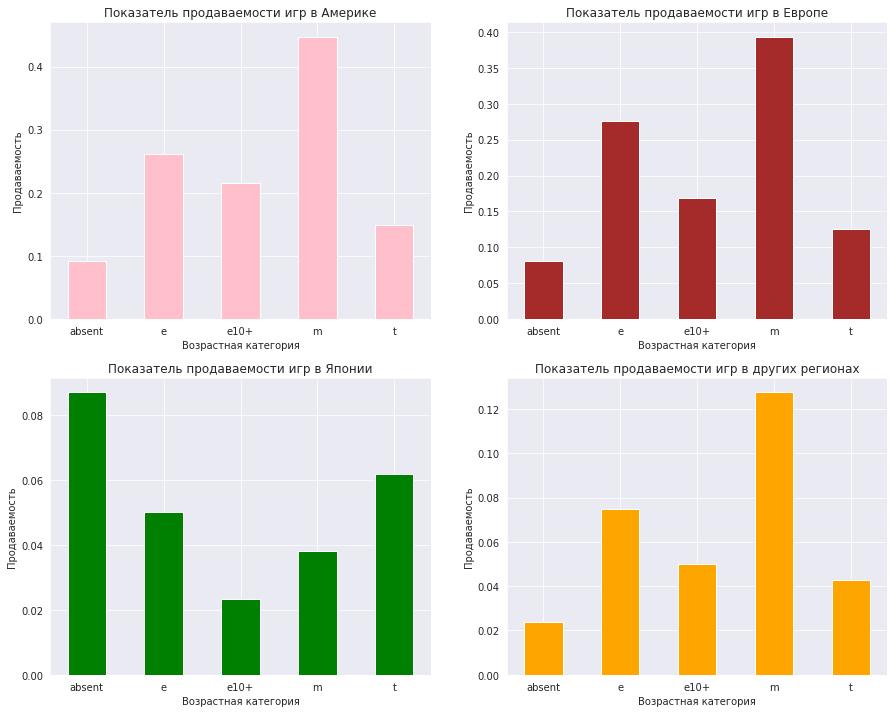

In [233]:
plt.figure(figsize=(15, 12))

plt.subplot(2, 2, 1)
plt.title('Показатель продаваемости игр в Америке')
plt.xlabel('Возрастная категория')
plt.ylabel('Продаваемость')
plt.bar(group_by_esrb_na.index, group_by_esrb_na['relative_sales'], color='pink', width=0.5)
plt.grid(True)

plt.subplot(2, 2, 2)
plt.title('Показатель продаваемости игр в Европе')
plt.xlabel('Возрастная категория')
plt.ylabel('Продаваемость')
plt.bar(group_by_esrb_eu.index, group_by_esrb_eu['relative_sales'], color='brown', width=0.5)
plt.grid(True)

plt.subplot(2, 2, 3)
plt.title('Показатель продаваемости игр в Японии')
plt.xlabel('Возрастная категория')
plt.ylabel('Продаваемость')
plt.bar(group_by_esrb_jp.index, group_by_esrb_jp['relative_sales'], color='green', width=0.5)
plt.grid(True)

plt.subplot(2, 2, 4)
plt.title('Показатель продаваемости игр в других регионах')
plt.xlabel('Возрастная категория')
plt.ylabel('Продаваемость')
plt.bar(group_by_esrb_other.index, group_by_esrb_other['relative_sales'], color='orange', width=0.5)
plt.grid(True)
plt.show()

Получаем диаграммы, из которых можно сделать вывод о том, что самый малочисленная возрастная категория в плане разнообразия игр это категория *m* - 18+. Это относится ко всем регионам, кроме Японии, в Японии одинаково мало (по сравнению с другими регионами) различных игр для категорий *m*, *t*, *e* и еще меньше для категории *absent*. Видимо в Японии эксперты более тщательно занимаются оценкой игр, и остается совсем немного тех, которые не получили возрастной рейтинг.

Также важно отметить тот факт, что в Японии наш искусственный коэффициент продаваемости самый низкий относительно других регионов, в сравнении с Америкой и Европой ниже приблизительно от 5 до 10 раз, что означает, что в Японии очень много различных игр и вероятно то, что там намного более развитая и конкурентная игровая индустрия (что вполне логично, это же Япония).

В Америке, Европе и других регионах значения по каждой категории сходны.

## Проверка статистических гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Проверим данную статистическую гипотезу. В данном случае гипотеза будет иметь двустороннюю критическую область, так как в ней проверяется равенство двух генеральных средних. Для начала создадим соответствующие срезы данных для платформ xone и pc. Затем визуализируем распределения их пользовательских оценок, для проверки нормальности распределения.

In [234]:
# Создадим соответствующие срезы и удалим пропуски в данных

stat_xone = data[data['platform'] == 'xone']['user_score']
stat_xone = stat_xone.dropna()
stat_pc = data[data['platform'] == 'pc']['user_score']
stat_pc = stat_pc.dropna()

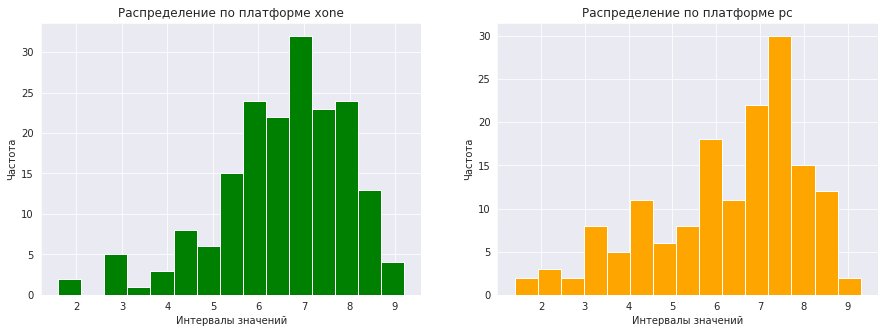

In [235]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Распределение по платформе xone')
plt.xlabel('Интервалы значений')
plt.ylabel('Частота')
plt.hist(stat_xone, bins=15, color='green')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Распределение по платформе pc')
plt.xlabel('Интервалы значений')
plt.ylabel('Частота')
plt.hist(stat_pc, bins=15, color='orange')
plt.grid(True)
plt.show()

In [236]:
print(f'{len(stat_xone)} - объем первой выборки\n{len(stat_pc)} - объем второй выборки')

182 - объем первой выборки
155 - объем второй выборки


Видим, что распределения по обоим платформам близко к нормальному, хотя и с небольшой скошенностью влево или отрицательной скшенностью.

Выборки в нашем случае большие, обе имеют более 30 вариант. Генеральные дисперсии нам неизвестны, к слову генеральные совокупности могут иметь и отличное от нормального распределение. Сформулируем нулевую и конкурирующую гипотезы.

H0: x1 = x2

Конкурирующая:

H1: x1 ≠ x2

где x1 и x2 - выборочные средние.

Проверим гипотезы сначала с помощью ручного расчета, затем используем метод *ttest_ind* модуля *stats* библиотеки *scipy*. Для проверки гипотезы будем использовать Z критерий, конкретно для данного случая он будет приближенный, так как генеральные дисперсии нам неизвестны. Для расчета по данному критерию необходимы такие параметры как выборочные средние каждой из выборок, дисперсии выборок (причем можно использовать и исправленные дисперсии, но в нашем случае при большом объеме выборок это не сильно повлияет на результат) а также значения объема рассматриваемых выборок. Приведем ниже все необходимые параметры.

In [237]:
print(f'Объем первой выборки N = {len(stat_xone)}\nОбъем второй выборки M = {len(stat_pc)}')

Объем первой выборки N = 182
Объем второй выборки M = 155


In [238]:
print(f'Выборочные средние:\nx1 = {stat_xone.mean().round(3)}\nx2 = {stat_pc.mean().round(3)}')

Выборочные средние:
x1 = 6.521
x2 = 6.27


In [239]:
# Используем метод var из быблиотеку numpy для нахождения дисперсии, при этом указываем аргумент ddof=1, который учитывает
# что в данном случае используется именно выборка
print(f'Дисперсия первой выборки: D(x1) = {np.var(stat_xone, ddof=1).round(3)}\nДисперсия второй выборки: D(x2) = {np.var(stat_pc, ddof=1).round(3)}')

Дисперсия первой выборки: D(x1) = 1.907
Дисперсия второй выборки: D(x2) = 3.036


Теперь найдем критические значения критической области. Число степеней свободы будет следующим:

*k = N + M -2 = 182 + 155 - 2 = 335*

Уровень значимости примем равным α = 0.05. Найдем критические значения *tкр.* по таблице критических точек распределения Стьюдента:

*tкр. = tдвустор.кр.(α; k) = tдвустор.кр.(0.05; 554) = 1.96*

Таким образом мы получили критическое значение равное 1.96. Если использовать таблицу функции Лапласа, то получим значение 1.97-1.98, приблизительно. Остановимся на значении 1.96. Так как конкурирующая гипотеза двустороняя, то нулевая гипотеза принимается при попадании рассматриваемого значения величины Z в интервал (-1.96; 1.96)

Наблюдаемое значение вычислим по формуле:

In [240]:
print('       x1 - x2\n--------------------\n√(D(x1)/N + D(x2)/M)')

       x1 - x2
--------------------
√(D(x1)/N + D(x2)/M)


После вычисления получаем, что Z = 1.447, следовательно полученное значение попадает в область принятия нулевой гипотезы, поэтому принимаем нулевую гипотезу на уровне статистической значимости 0.05.

Теперь проведем аналогичную проверку с помощью метода *ttest_ind*

In [241]:
# Используем агрумент equal_var со значением False, тем самым учитывая тот факт, что значения дисперсий выборок различны

results = st.ttest_ind(stat_xone, stat_pc, equal_var=False)
results.pvalue

0.14759594013430463

В соответствии с полученным значением вероятности (вероятности получить такие или еще более сильно отличающиеся значения) принимаем нулевую гипотезу о равенстве средних пользовательских рейтингов платформ xone и pc.

### Средние пользовательские рейтинги жанров Action  и Sports разные.

Проверим данную гипотезу аналогично. В данном случае также будем иметь дело с двусторонней критической областью, так как здесь проверяется неравенство двух генеральных средних. Создадим соответствующие срезы данных и проверим выборки на нормальность распределения.

In [242]:
stat_action = data[data['genre'] == 'action']['user_score']
stat_action = stat_action.dropna()
stat_sports = data[data['genre'] == 'sports']['user_score']
stat_sports = stat_sports.dropna()

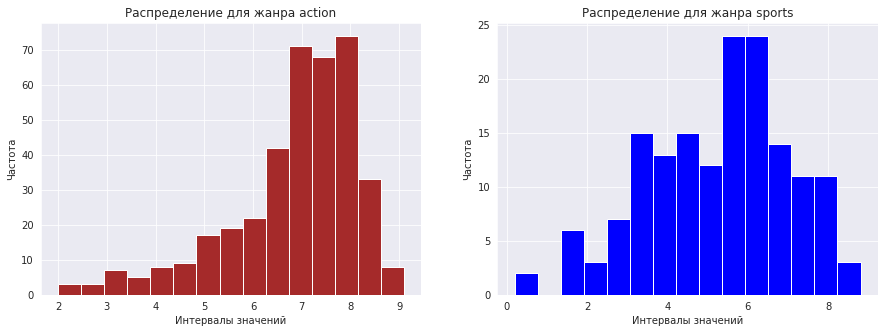

In [243]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Распределение для жанра action')
plt.xlabel('Интервалы значений')
plt.ylabel('Частота')
plt.hist(stat_action, bins=15, color='brown')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Распределение для жанра sports')
plt.xlabel('Интервалы значений')
plt.ylabel('Частота')
plt.hist(stat_sports, bins=15, color='blue')
plt.grid(True)
plt.show()

Видим, что распределения близки к нормальному, также с отрицательным смещением.

In [244]:
print(f'{len(stat_action)} - объем первой выборки\n{len(stat_sports)} - объем второй выборки')

389 - объем первой выборки
160 - объем второй выборки


Выборки в нашем случае большие, обе имеют более 30 вариант. Генеральные дисперсии нам неизвестны, генеральные совокупности могут иметь и отличное от нормального распределение. Сформулируем нулевую и конкурирующую гипотезы.

H0: x1 = x2

Конкурирующая:

H1: x1 ≠ x2

где x1 и x2 - выборочные средние.

Проверим гипотезы сначала также вручную, затем используем метод *ttest_ind*. Для проверки гипотезы будем использовать Z критерий, он также будет приближенный, так как генеральные дисперсии нам неизвестны. Приведем ниже все необходимые параметры.

In [245]:
print(f'Объем первой выборки N = {len(stat_action)}\nОбъем второй выборки M = {len(stat_sports)}')

Объем первой выборки N = 389
Объем второй выборки M = 160


In [246]:
print(f'Выборочные средние:\nx1 = {stat_action.mean().round(3)}\nx2 = {stat_sports.mean().round(3)}')

Выборочные средние:
x1 = 6.838
x2 = 5.238


In [247]:
# Используем метод var из быблиотеку numpy для нахождения дисперсии, при этом указываем аргумент ddof=1, который учитывает
# что в данном случае используется именно выборка
print(f'Дисперсия первой выборки: D(x1) = {np.var(stat_action, ddof=1).round(3)}\nДисперсия второй выборки: D(x2) = {np.var(stat_sports, ddof=1).round(3)}')

Дисперсия первой выборки: D(x1) = 1.769
Дисперсия второй выборки: D(x2) = 3.181


Теперь найдем критические значения критической области. Число степеней свободы будет следующим:

*k = N + M -2 = 389 + 160 - 2 = 547*

Уровень значимости примем равным α = 0.05. Найдем критические значения *tкр.* по таблице критических точек распределения Стьюдента:

*tкр. = tдвустор.кр.(α; k) = tдвустор.кр.(0.05; 1092) = 1.96*

Таким образом мы получили критическое значение равное 1.96. Так как конкурирующая гипотеза двустороняя, то нулевая гипотеза принимается при попадании рассматриваемого значения величины Z в интервал (-1.96; 1.96)

Наблюдаемое значение:

In [248]:
print('       x1 - x2\n--------------------\n√(D(x1)/N + D(x2)/M)')

       x1 - x2
--------------------
√(D(x1)/N + D(x2)/M)


После вычисления получаем, что Z = 10.24, следовательно полученное значение не попадает в область принятия нулевой гипотезы, поэтому отвергаем нулевую гипотезу в пользу конкурирующей на уровне статистической значимости 0.05.

Проведем аналогичную проверку с помощью метода *ttest_ind*

In [249]:
# Используем агрумент equal_var со значением False, тем самым учитывая тот факт, что значения дисперсий выборок различны

results = st.ttest_ind(stat_action, stat_sports, equal_var=False)
results.pvalue

1.4460039700704315e-20

В соответствии с полученным значением вероятности (вероятности получить такие или еще более сильно отличающиеся значения) отвергаем нулевую гипотезу о равенстве средних пользовательских рейтингов для жанров action и sports.

Делаем вывод, что средние оценки пользователей жанров action и sports статистически значимо различаются.

## Общий вывод

Итоговый вывод - рекомендации к составлению рекламных компаний на следующий год - разделим не несколько частей, а именно, сделаем вывод о ситуации в игровой сфере относительно жанров игр в каждом из рассматриваемых регионов, о ситуации относительно прибыльности каждой из платформ и о ситуации относительно популярности и распространенности игр в каждой из возрастных категорий.

 - Жанры. Если говорить и жанрах игр, то можно выделить топ-5 популярных жанров (по сумме продаж) для каждого из регионов и получить такое представление:
 
   1. Для Америки:
      - Action
      - Shooter
      - Sports
      - Role-playing
      - Misc
 
   2. Для Европы:
      - Action
      - Shooter
      - Sports
      - Role-playing
      - Misc
 
   3. Для Японии:
      - Role-playing
      - Action
      - Misc
      - Fightong
      - Shooter
 
   4. Для других регионов:
      - Action
      - Shooter
      - Sports
      - Role-playing
      - Misc
 - Платформы. Ситуация с объемом продаж для различных платформ, в целом, схожая для всех регионов, хотя Япония несколько выделяется. В данном случае можно выделить следующие 5 самых популярных (по объему продаж игр) платформ для всех регионов в целом:
 
    1. ps4
    2. xone
    3. ps3
    4. 3ds
    5. x360

Здесь важно отметить, что в Японии преобладает платформа 3ds, в то время как в других регионах первое место делять между собой ps4 и xone. В целом если говорить предполагать прибыльность только на 2017 год, то еще остаются вполне актуальны и все остальные приведенные выше платформы.

 - Возрастной рейтинг. Здесь получаем, что наименее занятая ниша это ниша игр с возрастным рейтингом *m*. Это характерно для всех регионов, кроме Японии. Более занятыми нишами по количеству производимых игр являюся детские игры, то есть с рейтингом *e* и *e10+* а также игры с отсутствующим рейтингом.
 
 Рынок Японии здесь нужно выделить отдально. Для этого региона в целом каждая из возрастных категорий занята в 5-10 раз большим количеством контента, нежели в других регионах, также в Японии популярны немного другие жанры, в частности Role-Playing, что говорит о том, что для Японский игровой рынок требует совершенно другого подхода для внедрения новых продуктов, а также он является намного более конкурентным.